# Stock_Prices_basicLSTM_vs_Prophet

[Illustrated Guide to LSTM’s and GRU’s: A step by step explanation](https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21)

In [29]:
import numpy as np
np.random.seed(15)
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as pdr
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

In [30]:
# Load data
company = 'AAPL'
start = dt.datetime(2012,1,1)
end = dt.datetime(2021,2,1)
prediction_days = 60

data = pdr.DataReader(company, 'yahoo', start, end)
data.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2021-01-26,144.300003,141.369995,143.600006,143.160004,98390600.0,142.946396
2021-01-27,144.300003,140.410004,143.429993,142.059998,140843800.0,141.848038
2021-01-28,141.990005,136.699997,139.520004,137.089996,142621100.0,136.885452
2021-01-29,136.740005,130.210007,135.830002,131.960007,177180600.0,131.763107
2021-02-01,135.380005,130.929993,133.750000,134.139999,106239800.0,133.939850


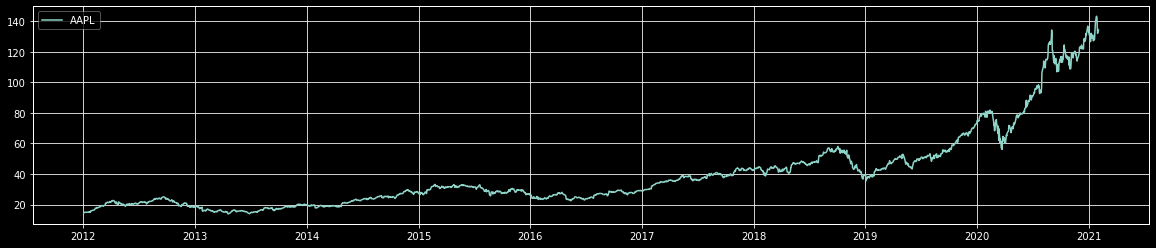

In [31]:
plt.style.use('dark_background')
plt.figure(figsize=(20,4))
plt.plot(data['Close'], label=f'{company}')
plt.legend()
plt.show()

In [32]:
# Prepare data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

In [33]:
x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
  x_train.append(scaled_data[x-prediction_days:x, 0])
  y_train.append(scaled_data[x, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [34]:
# Build the model
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1)) # Prediction of the next price closing

model.compile(optimizer='adam', loss='mean_squared_error')
print(model.summary(), '\n')
history = model.fit(x_train, y_train, epochs=10, batch_size=32, shuffle=False)

# model.save
# model.load

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 60, 50)            10400     
_________________________________________________________________
dropout_3 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_4 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_5 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

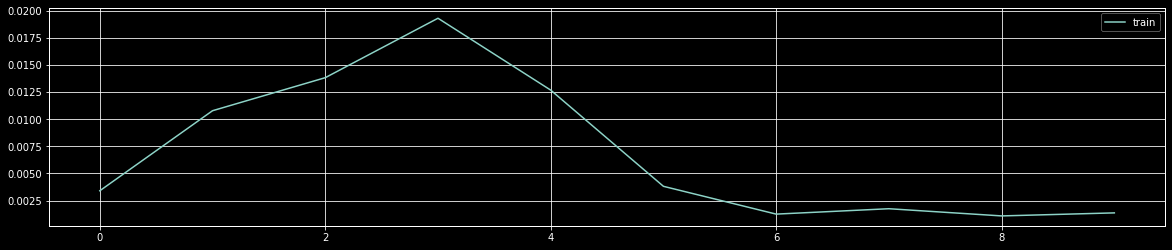

In [35]:
# plot history
plt.style.use('dark_background')
plt.figure(figsize=(20,4))
plt.plot(history.history['loss'], label='train')
plt.legend()
plt.show()

Test the model accuracy on existing data

In [36]:
# Load test data
test_start = end + dt.timedelta(days=1)
test_end = dt.datetime.now()

test_data = pdr.DataReader(company, 'yahoo', test_start, test_end)
actual_prices = test_data['Close'].values

total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)
# len(your_list) != len(set(your_list)) # check if duplicates

model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values # start ASAP
model_inputs = model_inputs.reshape(-1, 1)
model_inputs = scaler.transform(model_inputs)

In [37]:
# Make predictions on test data

x_test = []

for x in range(prediction_days, len(model_inputs)):
  x_test.append(model_inputs[x-prediction_days:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

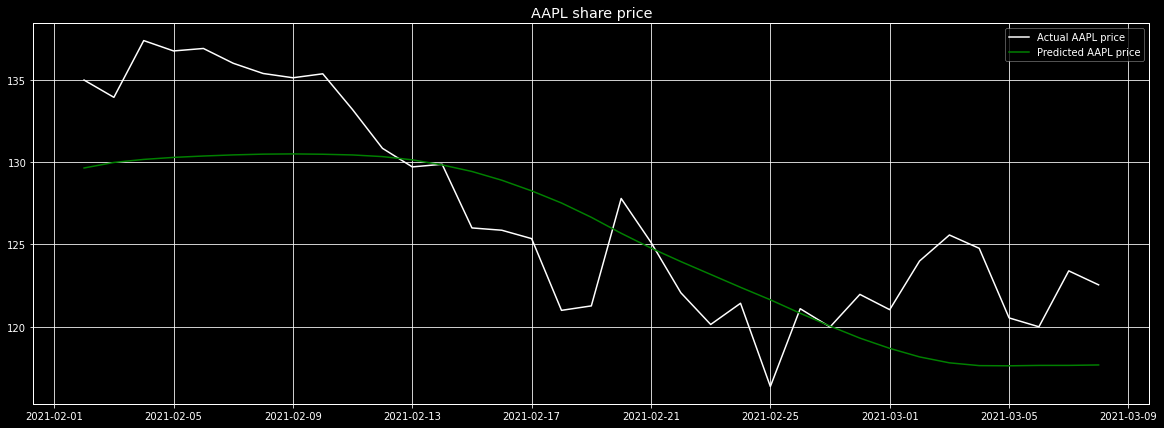

In [38]:
days = []
for i in range(len(test_data)):
    days.append(test_start + dt.timedelta(days=i))

# Plot the test predictions
plt.rcParams["figure.figsize"] = (20,7)
plt.plot(days, actual_prices, color='white', label=f'Actual {company} price')
plt.plot(days, predicted_prices, color='green', label=f'Predicted {company} price')
plt.title(f'{company} share price')
plt.legend()
plt.show()

In [39]:
# Predict next day

real_data = [model_inputs[len(model_inputs) + 1 - prediction_days : len(model_inputs + 1), 0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

In [40]:
current_day = str(test_data.index[-1]).split()[0]
current_price = round(float(test_data['Close'][-1]), 2)

prediction = model.predict(real_data)
prediction = round(float(scaler.inverse_transform(prediction)), 2)
next_day = str(test_data.index[-1] + dt.timedelta(days=1)).split()[0]

print('\n Current price:')
print(f'{current_day} {company}: {current_price} \n')

print('Next day prediction:')
print(f'{next_day} {company}: {prediction}')


 Current price:
2021-03-23 AAPL: 122.54 

Next day prediction:
2021-03-24 AAPL: 117.71


## Prophet

In [22]:
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot

In [23]:
prophet_df = total_dataset.to_frame()
prophet_df.reset_index(level = 0, inplace = True)
prophet_df.columns = ['ds', 'y']

prophet = Prophet()
prophet.fit(prophet_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


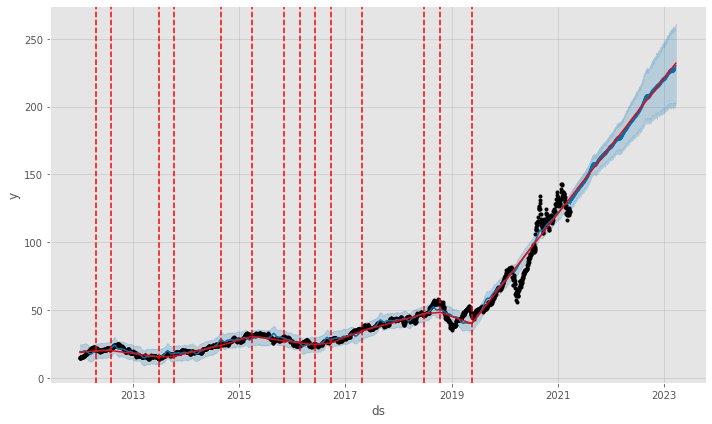

In [24]:
plt.style.use('ggplot')
future = prophet.make_future_dataframe(periods = 365*2)
forecast = prophet.predict(future)
fig = prophet.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet, forecast)

In [25]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
3045,2023-03-19,231.483398,198.998899,256.892660,204.015279,261.726525,-4.890973,-4.890973,-4.890973,-2.052480,-2.052480,-2.052480,-2.838494,-2.838494,-2.838494,0.0,0.0,0.0,226.592424
3046,2023-03-20,231.620260,201.084686,260.674169,204.099145,261.929468,-1.998401,-1.998401,-1.998401,0.810739,0.810739,0.810739,-2.809140,-2.809140,-2.809140,0.0,0.0,0.0,229.621859
3047,2023-03-21,231.757122,202.369202,260.620217,204.160541,262.132411,-1.897685,-1.897685,-1.897685,0.873106,0.873106,0.873106,-2.770791,-2.770791,-2.770791,0.0,0.0,0.0,229.859437
3048,2023-03-22,231.893984,202.686419,259.945354,204.199365,262.335354,-1.830028,-1.830028,-1.830028,0.894257,0.894257,0.894257,-2.724285,-2.724285,-2.724285,0.0,0.0,0.0,230.063956
3049,2023-03-23,232.030847,202.207063,261.294551,204.236854,262.538297,-1.845729,-1.845729,-1.845729,0.824841,0.824841,0.824841,-2.670570,-2.670570,-2.670570,0.0,0.0,0.0,230.185118


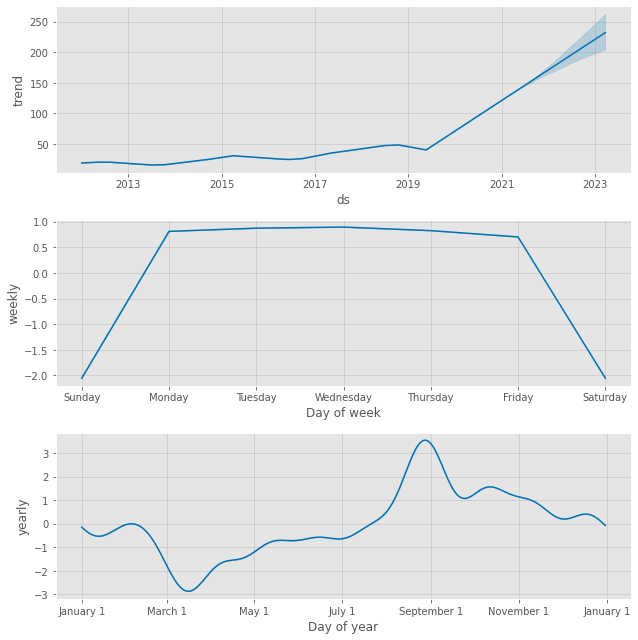

In [26]:
fig = prophet.plot_components(forecast)

In [27]:
forecast = forecast.set_index('ds')
next_day = str(test_data.index[-1] + dt.timedelta(days=1)).split()[0]
forecast.loc[[next_day]]

,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
ds,,,,,,,,,,,,,,,,,,
2021-03-24,132.258265,124.847031,135.920281,132.258265,132.258265,-1.684499,-1.684499,-1.684499,0.894257,0.894257,0.894257,-2.578757,-2.578757,-2.578757,0.0,0.0,0.0,130.573766


In [28]:
forecast = forecast[['yhat']]

current_day = str((forecast.loc[[next_day]].index - dt.timedelta(days=1)).date[0])
current_price = round(float(test_data['Close'][-1]), 2)

prediction = round(float(forecast.loc[[next_day]]['yhat']),2)
next_day = str((forecast.loc[[next_day]].index).date[0])

print('Current price:')
print(f'{current_day} {company}: {current_price} \n')

print('Next day prediction:')
print(f'{next_day} {company}: {prediction}')

Current price:
2021-03-23 AAPL: 122.54 

Next day prediction:
2021-03-24 AAPL: 130.57
